In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd

from jax import random, jit
import jax.numpy as jnp
import jax.nn 
from functools import partial

import arviz as az
import pickle as pkl

import os
import sys
sys.path.append('../')

from basiss.glmm import model_jit_de, model_jit_multiregion, model_jit_composition, mcmc_compile

In [2]:
%load_ext autoreload
%autoreload 2

## Running differential expression

In [3]:
file_names = [x.split('.')[0] for x in os.listdir('../submission/generated_data/glmm/DE_input')]
file_names = np.array(file_names)[[len(x) > 7 for x in file_names]]

PD9694l_Epithelial broad_green:DCIS_vs_orange:DCIS


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:15<00:00, 260.51it/s, 15 steps of size 3.24e-01. acc. prob=0.88]


PD14780a_Epithelial broad_purple:TC3_vs_dodgerblue:TC2


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:10<00:00, 371.05it/s, 7 steps of size 4.08e-01. acc. prob=0.88] 


PD14780e_Immune total_darkorange:['MC1', 'MC4']_vs_dodgerblue:MC2


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:16<00:00, 248.46it/s, 15 steps of size 3.30e-01. acc. prob=0.87]


PD14780e_Epithelial broad_darkorange:['MC1', 'MC4']_vs_dodgerblue:MC2


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:11<00:00, 342.32it/s, 7 steps of size 4.39e-01. acc. prob=0.82] 


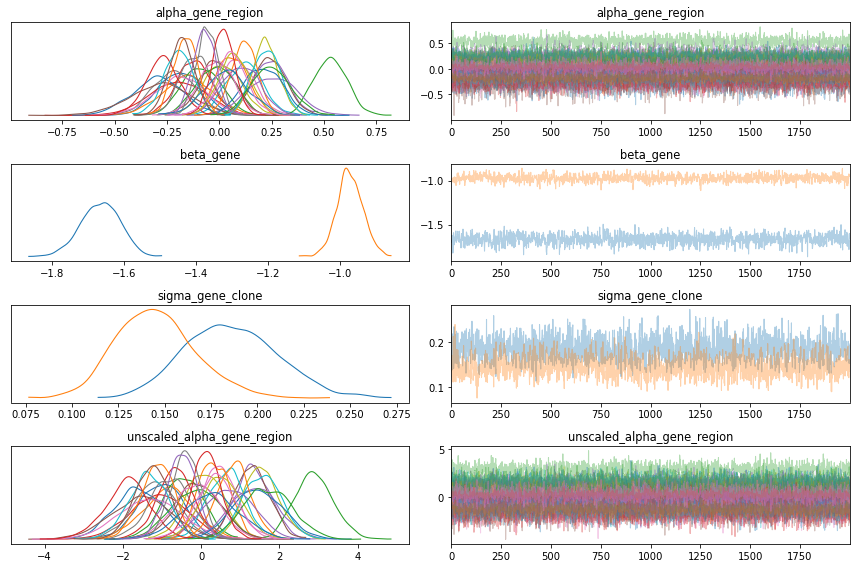

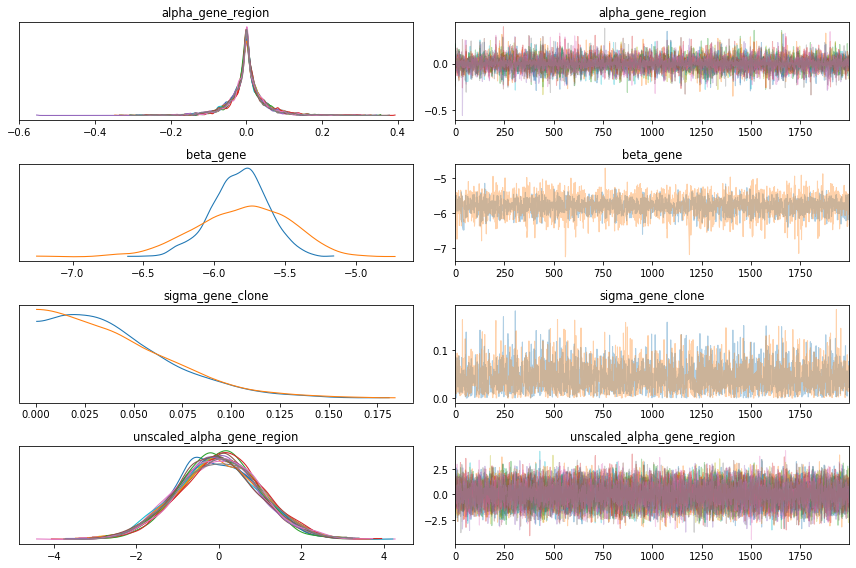

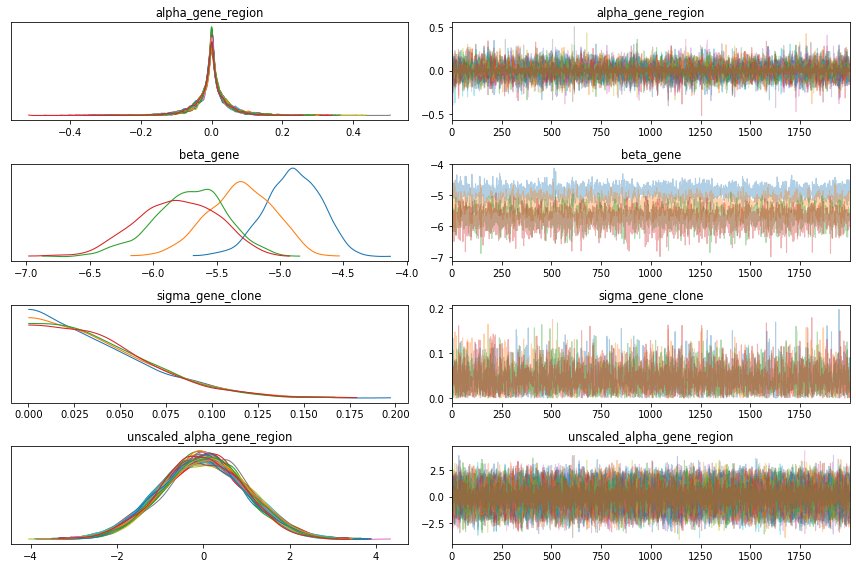

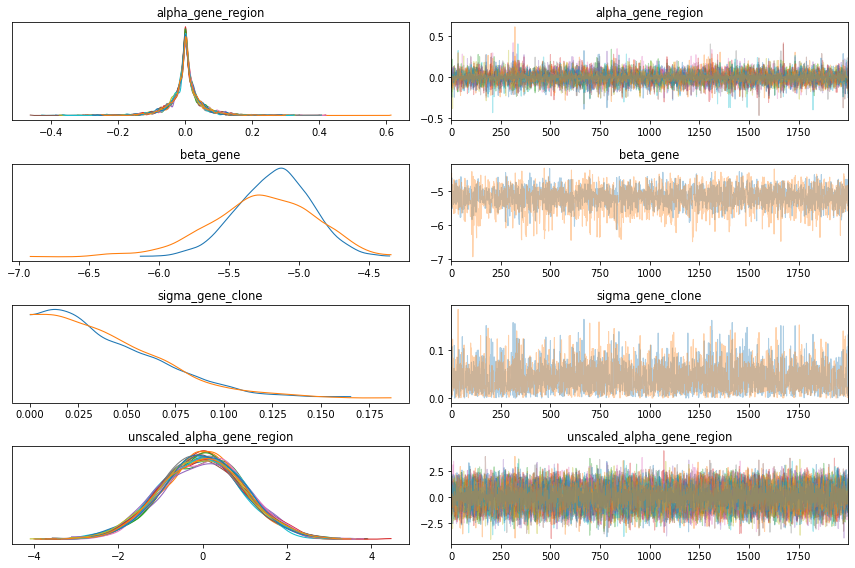

In [4]:
for file_name in file_names:
    print(file_name)
    data = pd.read_csv(f"../submission/generated_data/glmm/DE_input/{file_name}.csv", index_col=['gene','region'])
    n_regions = len(data.index.to_frame()['region'].unique())
    n_genes = len(data.index.to_frame()['gene'].unique())
    batch = 10
    def model_jit_de(x, y, g, r, r2c):
        with npy.plate("gene", batch):
            with npy.plate("clone", 2):
                beta_gene_clone = npy.sample("beta_gene", dist.Uniform(-10., 10.)) 
                sigma_gene_clone = npy.sample("sigma_gene_clone", dist.HalfNormal(0.05))
            with npy.plate("region", n_regions):
                unscaled_alpha_gene_region = npy.sample("unscaled_alpha_gene_region", dist.Normal(0., 1.))
            alpha_gene_region = npy.deterministic("alpha_gene_region", unscaled_alpha_gene_region * sigma_gene_clone[r2c])
        #print(sigma_gene_clone.shape)
        rho = jnp.array([alpha_gene_region[i] for i in zip(r,g)])
        mu = jnp.array([beta_gene_clone[i] for i in zip(r2c[r],g)])#alpha_gene[g] * (r2c[r]+0.0) + beta_gene[g] + rho
        with npy.plate("data", n_regions * batch):
            npy.sample("obs", dist.Poisson(rate=jnp.exp(mu + rho)*x), obs=y)

    nuts_kernel = NUTS(model_jit_de)
    mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, jit_model_args=True, num_chains=1)
    rng_key = random.PRNGKey(0)

    f = data.index.to_frame()
    genes = f['gene'].astype('category')
    regions = f['region'].astype('category')
    clones = data['clone_id'].values
    g = genes.cat.codes.values
    
    x = data.n_nucl.values
    y = data.value.values

    p = len(genes.cat.categories)
    q = len(regions.cat.categories)
    
    r2c = data.loc[genes.cat.categories[0],'clone_id'].values
    r = np.tile(np.arange(n_regions),batch)
    
    res = []
    for i in range(int(n_genes/batch)):
        j = i * n_regions * batch
        k = (i+1) * n_regions * batch
        mcmc.run(rng_key, x[j:k], y[j:k], g[j:k] % batch, r, r2c)
        beta = mcmc.get_samples()['beta_gene']
        res.append(np.array(beta))
        
    last_batch = n_genes % batch
    
    if last_batch != 0:
    
        r = np.tile(np.arange(n_regions),last_batch)
        def model_jit_de(x, y, g, r, r2c):
            with npy.plate("gene", last_batch):
                with npy.plate("clone", 2):
                    beta_gene_clone = npy.sample("beta_gene", dist.Uniform(-10., 10.)) 
                    sigma_gene_clone = npy.sample("sigma_gene_clone", dist.HalfNormal(0.05))
                with npy.plate("region", n_regions):
                    unscaled_alpha_gene_region = npy.sample("unscaled_alpha_gene_region", dist.Normal(0., 1.))
            alpha_gene_region = npy.deterministic("alpha_gene_region", unscaled_alpha_gene_region * sigma_gene_clone[r2c])

            #print(sigma_gene_clone.shape)
            rho = jnp.array([alpha_gene_region[i] for i in zip(r,g)])
            mu = jnp.array([beta_gene_clone[i] for i in zip(r2c[r],g)])
            with npy.plate("data", n_regions * last_batch):
                npy.sample("obs", dist.Poisson(rate=jnp.exp(mu + rho)*x), obs=y)
                
        nuts_kernel = NUTS(model_jit_de)
        mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, jit_model_args=True, num_chains=1)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, x[k:], y[k:], g[k:] % last_batch, r, r2c)
        beta = mcmc.get_samples()['beta_gene']
        res.append(np.array(beta))
        
    beta = np.concatenate(res, axis=2)
    
    np.save(f'../submission/generated_data/glmm/DE_output/{file_name}.npy', beta)
    
    posterior = az.from_numpyro(mcmc)
    az.plot_trace(posterior,compact=True)
    plt.tight_layout()

## Runing multiregional expression model (an extension of DE model)

In [5]:
file_names = [x.split('.')[0] for x in os.listdir('../submission/generated_data/glmm/multiregion_input')]
file_names = np.array(file_names)[[len(x) > 7 for x in file_names]]

PD9694a_Epithelial broad


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:12<00:00, 323.21it/s, 15 steps of size 2.41e-01. acc. prob=0.90]


PD9694c_Epithelial broad


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:15<00:00, 256.86it/s, 15 steps of size 3.32e-01. acc. prob=0.86]


PD14780a_Epithelial broad


  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:11<00:00, 345.96it/s, 15 steps of size 3.13e-01. acc. prob=0.85]


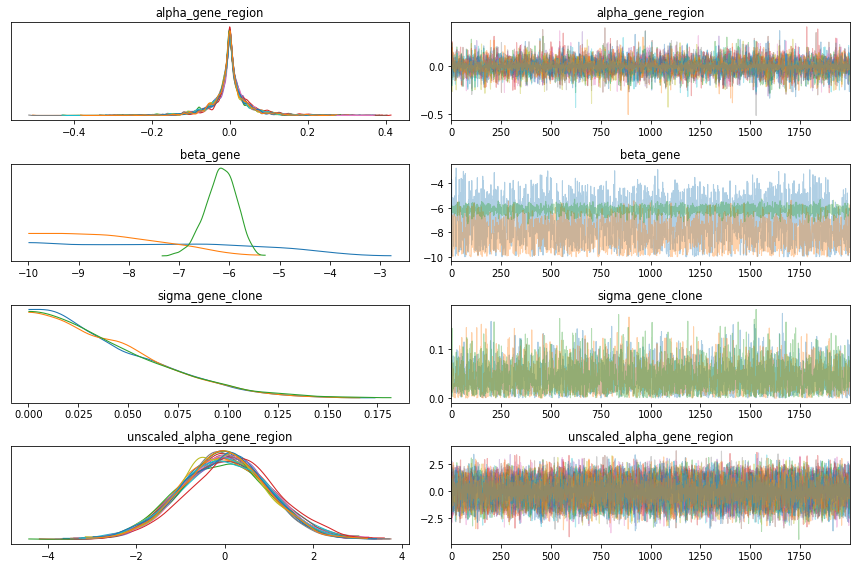

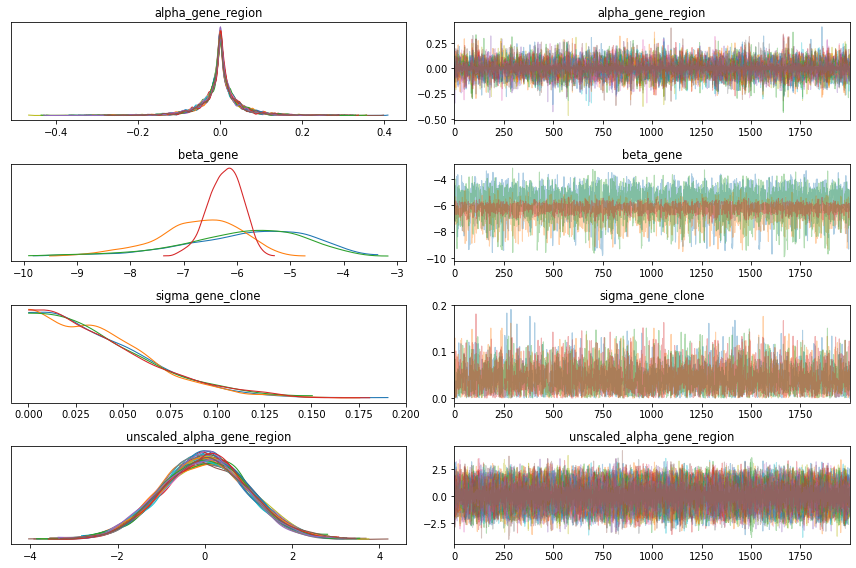

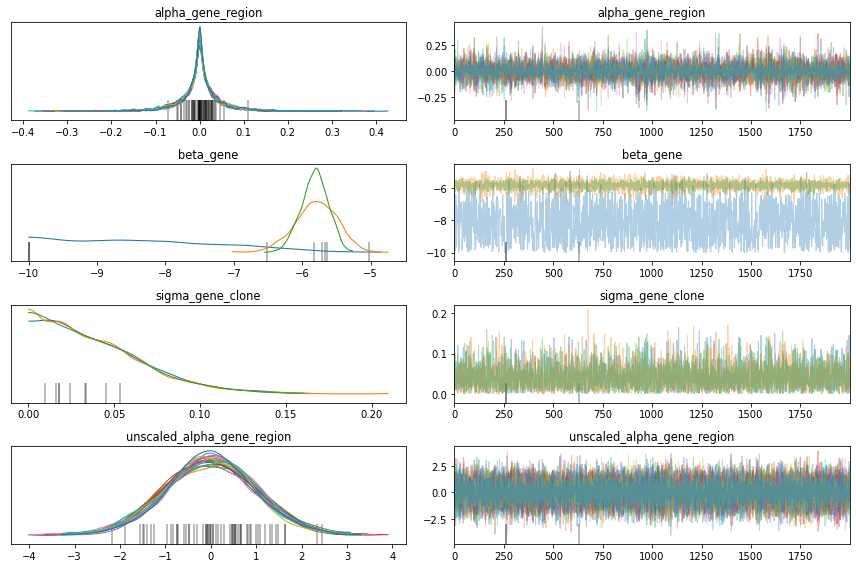

In [6]:
for file_name in file_names:
    print(file_name)
    data = pd.read_csv(f"../submission/generated_data/glmm/multiregion_input/{file_name}.csv", index_col=['gene','region'])
    n_regions = len(data.index.to_frame()['region'].unique())
    n_genes = len(data.index.to_frame()['gene'].unique())
    n_clones = len(data['clone_id'].unique())
    batch = 10
    def model_jit_multiregion(x, y, g, r, r2c):
        with npy.plate("gene", batch):
            with npy.plate("clone", n_clones):
                beta_gene_clone = npy.sample("beta_gene", dist.Uniform(-10., 10.)) 
                sigma_gene_clone = npy.sample("sigma_gene_clone", dist.HalfNormal(0.05))
            with npy.plate("region", n_regions):
                unscaled_alpha_gene_region = npy.sample("unscaled_alpha_gene_region", dist.Normal(0., 1.))
            alpha_gene_region = npy.deterministic("alpha_gene_region", unscaled_alpha_gene_region * sigma_gene_clone[r2c])
        #print(sigma_gene_clone.shape)
        rho = jnp.array([alpha_gene_region[i] for i in zip(r,g)])
        mu = jnp.array([beta_gene_clone[i] for i in zip(r2c[r],g)])#alpha_gene[g] * (r2c[r]+0.0) + beta_gene[g] + rho
        with npy.plate("data", n_regions * batch):
            npy.sample("obs", dist.Poisson(rate=jnp.exp(mu + rho)*x), obs=y)

    nuts_kernel = NUTS(model_jit_multiregion)
    mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, jit_model_args=True, num_chains=1)
    rng_key = random.PRNGKey(0)

    f = data.index.to_frame()
    genes = f['gene'].astype('category')
    regions = f['region'].astype('category')
    clones = data['clone_id'].values
    g = genes.cat.codes.values
    r = np.tile(np.arange(n_regions),10) #regions.cat.codes.values
    x = data.n_nucl.values
    y = data.value.values

    p = len(genes.cat.categories)
    q = len(regions.cat.categories)

    r2c = data.loc[genes.cat.categories[0],'clone_id'].values

    res = []
    for i in range(int(n_genes/batch)):
        j = i * n_regions * batch
        k = (i+1) * n_regions * batch
        mcmc.run(rng_key, x[j:k], y[j:k], g[j:k] % batch, r, r2c)
        beta = mcmc.get_samples()['beta_gene']
        res.append(np.array(beta))
        
    last_batch = n_genes % batch
    
    if last_batch != 0:
        r = np.tile(np.arange(n_regions),last_batch)
        def model_jit_de(x, y, g, r, r2c):
            with npy.plate("gene", last_batch):
                with npy.plate("clone", n_clones):
                    beta_gene_clone = npy.sample("beta_gene", dist.Uniform(-10., 10.)) 
                    sigma_gene_clone = npy.sample("sigma_gene_clone", dist.HalfNormal(0.05))
                with npy.plate("region", n_regions):
                    unscaled_alpha_gene_region = npy.sample("unscaled_alpha_gene_region", dist.Normal(0., 1.))
            alpha_gene_region = npy.deterministic("alpha_gene_region", unscaled_alpha_gene_region * sigma_gene_clone[r2c])
            #print(sigma_gene_clone.shape)
            rho = jnp.array([alpha_gene_region[i] for i in zip(r,g)])
            mu = jnp.array([beta_gene_clone[i] for i in zip(r2c[r],g)])
            with npy.plate("data", n_regions * last_batch):
                npy.sample("obs", dist.Poisson(rate=jnp.exp(mu + rho)*x), obs=y)
                
        nuts_kernel = NUTS(model_jit_de)
        mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, jit_model_args=True, num_chains=1)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, x[k:], y[k:], g[k:] % last_batch, r, r2c)
        beta = mcmc.get_samples()['beta_gene']
        res.append(np.array(beta))
    
    beta = np.concatenate(res, axis=2)
    
    np.save(f'../submission/generated_data/glmm/multiregion_output/{file_name}.npy', beta)
    
    posterior = az.from_numpyro(mcmc)
    az.plot_trace(posterior,compact=True)
    plt.tight_layout()

## Runing multiregional compositional model (cell types)

In [7]:
file_names = [x.split('.')[0] for x in os.listdir('../submission/generated_data/glmm/composition_input/')]
file_names = np.array(file_names)[[len(x) > 7 for x in file_names]]

/tmp/ipykernel_950132/3760832065.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_pivoted = pd.pivot(pd.concat([data, f], 1), index=['panel', 'celltype'], columns='region', values='value')
/tmp/ipykernel_950132/3760832065.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  r2c = data[f.panel == panels[i_panel]].loc[celltypes.cat.categories[0],'clone_id'][regions].values
  0%|          | 0/4000 [00:00<?, ?it/s]/hps/software/users/gerstung/alomakin/miniconda3/envs/pyro-env/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 4000/4000 [00:11<00:00, 333.78it/s, 255 steps of size 5.57e-02. acc. prob=0.90]
/tmp/ipykernel_950132/

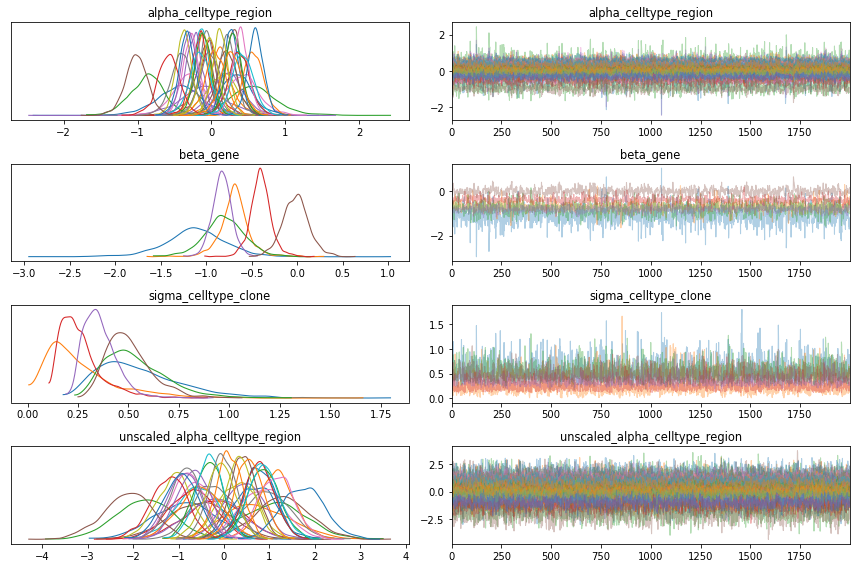

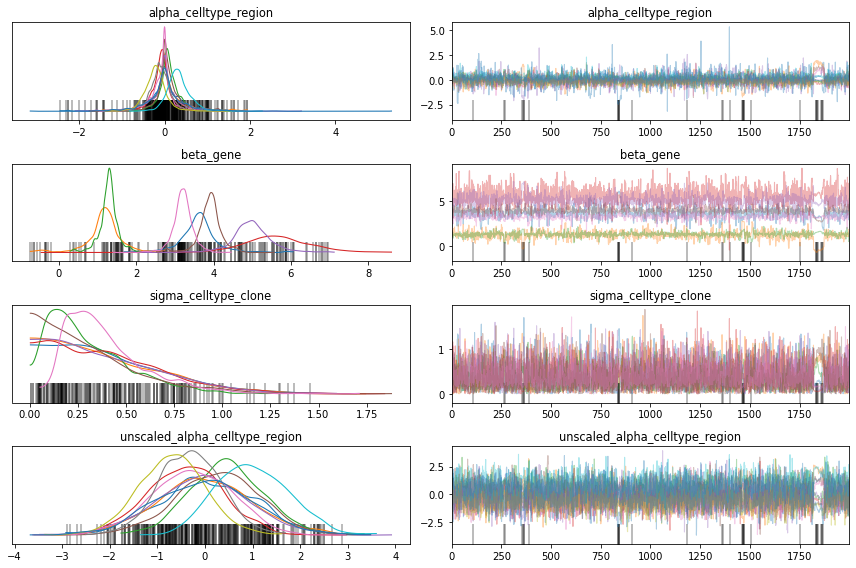

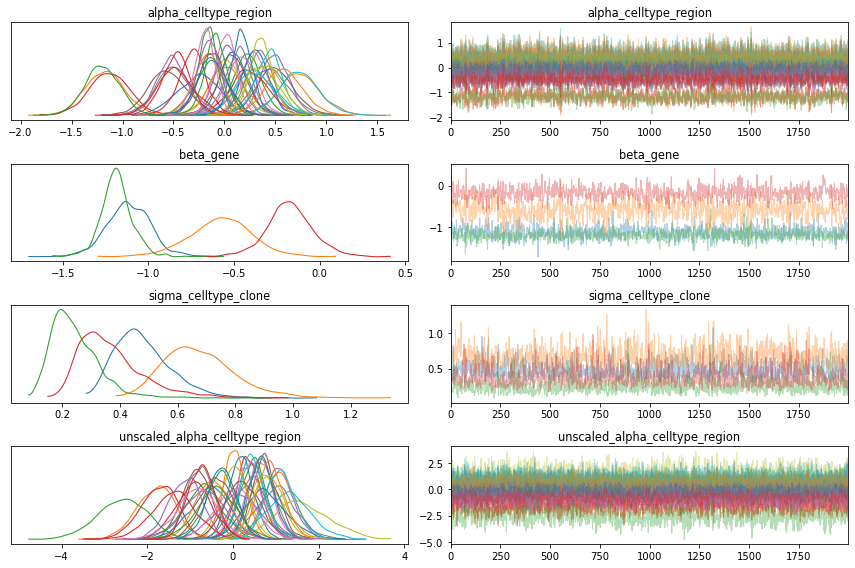

In [8]:
for file_name in file_names:
    data = pd.read_csv(f"../submission/generated_data/glmm/composition_input/{file_name}.csv", index_col=['cell','region', 'panel'])
    data.index = data.index.rename(['celltype', 'region', 'panel'])
    f = data.index.to_frame()
    df_pivoted = pd.pivot(pd.concat([data, f], 1), index=['panel', 'celltype'], columns='region', values='value')
    panels = f['panel'].unique()

    result = []
    celltype_joinded = []

    for i_panel in range(len(panels)):
        panels = f['panel'].unique()
        dat_pivot = df_pivoted.loc[panels[i_panel]]
        celltypes = pd.Series(dat_pivot.index.astype('category'))
        regions = pd.Series(dat_pivot.columns.astype('category'))

        r2c = data[f.panel == panels[i_panel]].loc[celltypes.cat.categories[0],'clone_id'][regions].values
        n_regions = len(regions.cat.categories)
        n_celltypes = len(celltypes.cat.categories)
        n_clones = len(data.clone_id.unique())

        ct = celltypes.cat.codes.values
        r = regions.cat.codes.values
        y = dat_pivot.values.T

        def model_composition():
            with npy.plate("celltype", n_celltypes-1):
                with npy.plate("clone", n_clones):
                    beta_celltype_clone = npy.sample("beta_gene", dist.Uniform(-10., 10.)) 
                    sigma_celltype_clone = npy.sample("sigma_celltype_clone", dist.HalfNormal(0.5))
                with npy.plate("region", n_regions):
                    unscaled_alpha_gene_region = npy.sample("unscaled_alpha_celltype_region", dist.Normal(0., 1.))
            alpha_celltype_region = npy.deterministic("alpha_celltype_region", unscaled_alpha_gene_region * sigma_celltype_clone[r2c])
            
            rho = alpha_celltype_region
            mu = jnp.array([beta_celltype_clone[i] for i in r2c[r]])    #print(sigma_gene_clone.shape)

            lam = jnp.concatenate([mu + rho, jnp.ones((n_regions, 1))], axis=1)
            with npy.plate("data", n_regions):
                npy.sample("obs", dist.Multinomial(probs=jax.nn.softmax(lam)), obs=y)

        nuts_kernel = NUTS(model_composition)
        mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000, jit_model_args=True, num_chains=1)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key)

        beta = mcmc.get_samples()['beta_gene']
        beta = np.concatenate([np.array(beta), np.ones(beta.shape[:-1])[:,:,None]], axis=2)
        result.append(beta)
        celltype_joinded.append(celltypes)

    with open(f'../submission/generated_data/glmm/composition_ouput/{file_name}.pkl', 'wb') as file:
        pkl.dump(result, file)

    posterior = az.from_numpyro(mcmc)
    az.plot_trace(posterior,compact=True)
    plt.tight_layout()